# JWST-ERS Clusters

The goal of this notebook is to build a handful of "truth" spectra that we can simulate using the [JWST Exposure Time Calculator](https://jwst.etc.stsci.edu).

In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, Column
from astropy.io import fits

from prospect.sources import CSPSpecBasis

In [2]:
%matplotlib inline

In [3]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

### Initialize the SSPs.

In [4]:
t0 = time.time()
print('Initializing CSPSpecBasis...')
sps = CSPSpecBasis(zcontinuous=1, compute_vega_mags=False, vactoair_flag=False)
print('...took {:.1f} seconds.'.format(time.time() - t0)) 

Initializing CSPSpecBasis...
...took 10.9 seconds.


### Define the sample and physical properties of the "galaxies" to simulate.

In [5]:
nspec = 2
npix = len(sps.csp.wavelengths)
jwstdir = os.path.join( os.getenv('IM_PROJECTS_DIR'), 'jwstclusters' )

In [6]:
cat = Table()
cat.add_column(Column(name='WAVELENGTH', shape=(npix,), length=nspec, 
                      dtype='f4', unit=u.micron))
cat.add_column(Column(name='FLUX', shape=(npix,), length=nspec, dtype='f4', unit=u.mJy))
cat.add_column(Column(name='ID', length=nspec, dtype='i4'))
cat.add_column(Column(name='ZRED', length=nspec, dtype='f4'))  # observed redshift
cat.add_column(Column(name='ZFORM', length=nspec, dtype='f4')) # formation redshift
cat.add_column(Column(name='LOGMASS', length=nspec, dtype='f4', unit=u.solMass))
cat.add_column(Column(name='LOGZSOL', length=nspec, dtype='f4'))
cat.add_column(Column(name='TAU', length=nspec, dtype='f4', unit=u.Gyr))
cat.add_column(Column(name='TAGE', length=nspec, dtype='f4', unit=u.Gyr))

In [7]:
cat['ID'] = np.arange(nspec)
cat['LOGMASS'] = np.array([11.0, 10.0]).astype('f4') * u.solMass
cat['TAU'] = np.array([0.1, 0.1]).astype('f4') * u.Gyr
cat['LOGZSOL'] = np.log10( [1.5, 0.5] ).astype('f4') # super-solar and sub-solar
cat['ZRED'] = 1.5  # fixed redshift
cat['ZFORM'] = 5.0 # fixed formation redshift
cat['TAGE'] = (cosmo.age(cat['ZRED']) - cosmo.age(cat['ZFORM'])).astype('f4')
cat

WAVELENGTH [5994],FLUX [5994],ID,ZRED,ZFORM,LOGMASS,LOGZSOL,TAU,TAGE
micron,mJy,,,,solMass,,Gyr,Gyr
float32,float32,int64,float32,float32,float32,float32,float32,float32
0.0 .. 0.0,0.0 .. 0.0,0,1.5,5.0,11.0,0.176091,0.1,3.04597
0.0 .. 0.0,0.0 .. 0.0,1,1.5,5.0,10.0,-0.30103,0.1,3.04597


In [8]:
def logmass2mass(logmass=11.0, **extras):
    return 10**logmass

In [9]:
def load_model(cat):
    """Load the model parameters. For more documentation see
    http://dan.iel.fm/python-fsps/current/stellarpop_api/#api-reference

    """
    from prospect.models import priors, sedmodel

    model_params = []

    ##################################################
    # Fixed priors

    # Galaxy redshift
    model_params.append({
        'name': 'zred',
        'N': 1,
        'isfree': False,
        'init': cat['ZRED'],
        'prior': None,       
        })

    model_params.append({ # current mass in stars, not integral of SFH
        'name': 'mass_units',
        'N': 1,
        'isfree': False,
        'init': 'mstar', # 'mformed'
        'prior': None,       
        })

    # IMF
    model_params.append({
        'name': 'imf_type',
        'N': 1,
        'isfree': False,
        'init':   0, # 0=Salpeter, 1=Chabrier, 2=Kroupa
        'prior': None,       
        })

    # SFH parameterization (delayed-tau)
    model_params.append({
        'name': 'sfh',
        'N': 1,
        'isfree': False,
        'init':   4, # 4 = delayed tau model
        'prior': None,       
        })

    # Do not include dust emission
    model_params.append({
        'name': 'add_dust_emission',
        'N': 1,
        'isfree': False,
        'init':   False, # do not include dust emission
        'prior': None,       
        })

    # Prior(s) on dust content
    model_params.append({
        'name': 'dust2',
        'N': 1,
        'isfree': False,
        'init': 0.0,
        'prior': None,
        })
    
    ##################################################
    # Free priors / parameters

    # Priors on stellar mass and stellar metallicity
    model_params.append({
        'name': 'logmass',
        'N': 1,
        'isfree': True,
        'init': cat['LOGMASS'],
        'prior': None,
        })
    
    model_params.append({
        'name': 'mass',
        'N': 1,
        'isfree': False,
        'init': 10**cat['LOGMASS'],
        'prior': None,
        'depends_on': logmass2mass,
        })

    model_params.append({
        'name': 'logzsol',
        'N': 1,
        'isfree': True,
        'init': cat['LOGZSOL'],
        'prior': None,
        })

    # Priors on tau and age
    model_params.append({
        'name': 'tau',
        'N': 1,
        'isfree': True,
        'init': cat['TAU'],
        'prior': None,
        })

    model_params.append( {
        'name': 'tage',
        'N': 1,
        'isfree': True,
        'init': cat['TAGE'],
        'prior': None,
        })

    model = sedmodel.SedModel(model_params)
    
    return model

### Build each model.

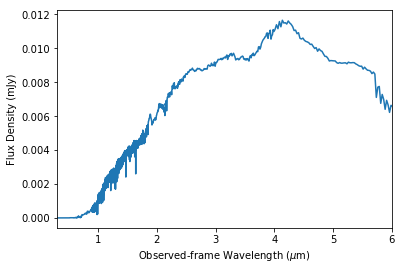

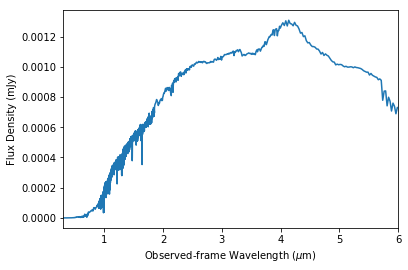

In [10]:
for ii in range(nspec):
    model = load_model(cat[ii])    
    
    obswave = sps.csp.wavelengths * (1 + cat['ZRED'][ii]) 
    cat['WAVELENGTH'][ii] = obswave / 1e4 * u.micron 
    
    obs = dict(
        filters = None,
        wavelength = obswave
    )
    model_flux, _, _ = model.mean_model(model.theta, obs, sps=sps)
    cat['FLUX'][ii] = model_flux * 10**(0.4 * 16.4) * u.mJy # maggies --> mJy

    if True:
        fig, ax = plt.subplots()
        ax.plot(cat['WAVELENGTH'][ii], cat['FLUX'][ii])
        ax.set_xlim(0.3, 6.0)
        ax.set_xlabel(r'Observed-frame Wavelength ($\mu$m)')
        ax.set_ylabel('Flux Density (mJy)')

### Write out.

In [11]:
def write_bintable(filename, data, header=None, comments=None, units=None,
                   extname=None, overwrite=True):
    """Utility function to write a FITS binary table complete with
    comments and units in the FITS header too.  DATA can either be
    dictionary, an Astropy Table, a numpy.recarray or a numpy.ndarray.

    """
    # hdu = astropy.io.fits.BinTableHDU(outdata, header=header, name=extname)
    hdu = fits.convenience.table_to_hdu(data)
    if extname is not None:
        hdu.header['EXTNAME'] = extname

    if header is not None:
        for key, value in header.items():
            hdu.header[key] = value

    #- Write the data and header
    fits.writeto(filename, hdu.data, hdu.header, overwrite=overwrite, checksum=True)

    #- Allow comments and units to be None
    if comments is None:
        comments = dict()
    if units is None:
        units = dict()

    #- Reopen the file to add the comments and units
    fx = fits.open(filename, mode='update')
    hdu = fx[extname]
    for i in range(1,999):
        key = 'TTYPE'+str(i)
        if key not in hdu.header:
            break
        else:
            value = hdu.header[key]
            if value in comments:
                hdu.header[key] = (value, comments[value])
            if value in units:
                hdu.header['TUNIT'+str(i)] = (units[value], value+' units')

    #- Write updated header and close file
    fx.flush()
    fx.close()

In [12]:
catfile = os.path.join(jwstdir, 'jwstclusters-etcspec.fits')
print('Writing {}'.format(catfile))
cat.write(catfile, overwrite=True)

for ii in range(nspec):
    specfile = os.path.join(jwstdir, 'galaxyspec_{0:02d}.txt'.format(cat['ID'][ii]))
    print('Writing {}'.format(specfile))
    np.savetxt(specfile, np.vstack( (cat['WAVELENGTH'][ii].data, cat['FLUX'][ii]) ).T)
    #Table(cat[ii]).write(specfile, include_names=['WAVELENGHT', 'FLUX'], 
    #                     overwrite=True, format='ascii')

Writing /Users/ioannis/research/projects/jwstclusters/jwstclusters-etcspec.fits
Writing /Users/ioannis/research/projects/jwstclusters/galaxyspec_00.txt
Writing /Users/ioannis/research/projects/jwstclusters/galaxyspec_01.txt
